In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import tqdm

import hetmech.hetmat
import hetmech.degree_group
import hetmech.degree_weight
import hetmech.pipeline

%matplotlib inline

In [2]:
hetmat = hetmech.hetmat.HetMat('../data/hetionet-v1.0.hetmat/')

In [3]:
metapaths = ['DaGbC', 'SpDpS', 'SEcCrCtD']

## Compute p-values for the actual HetMat

In [4]:
hetmat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(hetmat, allocate_GB=10)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, damping=0, dense_threshold=0.7, dtype='uint64')
    path = hetmat.get_path_counts_path(metapath, 'dwpc', 0, None)
    if not path.exists():
        hetmech.hetmat.save_matrix(pc_matrix, path)
    
hetmat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(hetmat, allocate_GB=10)
mean_dwpcs = dict()
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')
    mean_dwpcs[(metapath, 'dwpc', 0.5)] = dwpc_matrix.mean()
    path = hetmat.get_path_counts_path(metapath, 'dwpc', 0.5, None)
    if not path.exists():
        hetmech.hetmat.save_matrix(dwpc_matrix, path)

100%|██████████| 3/3 [00:00<00:00, 17.71it/s]


In [5]:
for name, permat in tqdm.tqdm((hetmat.permutations.items())):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=10)
    for metapath in metapaths:
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=mean_dwpcs[(metapath, 'dwpc', 0.5)], damping=0.5)
        path = hetmat.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.path_counts_cache = None

# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = hetmat.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = hetmat.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

100%|██████████| 200/200 [02:39<00:00,  1.26it/s]


In [4]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(hetmat, metapath, damping=0.5, ignore_zeros=True, max_p_value=1.0)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                     'adjusted-dwpcs', f'{metapath}.tsv.gz')
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')

100%|██████████| 3/3 [00:10<00:00,  3.50s/it]


## Compute p-values for a permat - Permutation 1

In [6]:
perms = hetmat.permutations.copy()
permat_1 = perms.pop('001')

In [ ]:
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0, dense_threshold=0.7, dtype='uint64')
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(pc_matrix, path)
    del pc_matrix
    
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
mean_dwpcs = dict()
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')
    mean_dwpcs[(metapath, 'dwpc', 0.5)] = dwpc_matrix.mean()
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0.5, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(dwpc_matrix, path)
    del dwpc_matrix

In [ ]:
for name, permat in tqdm.tqdm(perms.items()):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=16)
    for metapath in metapaths:
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=mean_dwpcs[(metapath, 'dwpc', 0.5)], damping=0.5)
        path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
        path.parent.mkdir(parents=True, exist_ok=True)
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.path_counts_cache = None

# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

In [ ]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(permat_1, metapath, damping=0.5, ignore_zeros=True, max_p_value=1.0)
    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    path.parent.mkdir(parents=True, exist_ok=True)
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')

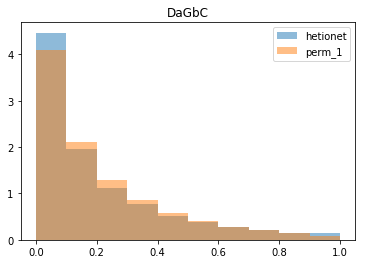

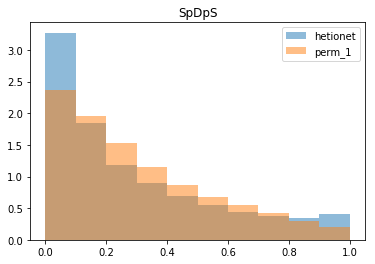

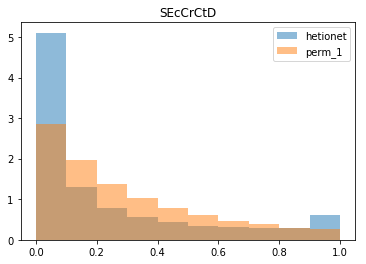

In [7]:
for metapath in metapaths:
    plt.figure()
    plt.title(metapath)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                     'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    plt.hist(df['p_value'], label='hetionet', alpha=0.5, density=True)
    

    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    plt.hist(df['p_value'], label='perm_1', alpha=0.5, density=True)
    plt.legend();

### Permutation 2

In [8]:
perms = hetmat.permutations.copy()
permat_1 = perms.pop('002')

In [ ]:
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0, dense_threshold=0.7, dtype='uint64')
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(pc_matrix, path)
    del pc_matrix
    
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
mean_dwpcs = dict()
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')
    mean_dwpcs[(metapath, 'dwpc', 0.5)] = dwpc_matrix.mean()
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0.5, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(dwpc_matrix, path)
    del dwpc_matrix

In [ ]:
for name, permat in tqdm.tqdm(perms.items()):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=16)
    for metapath in metapaths:
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=mean_dwpcs[(metapath, 'dwpc', 0.5)], damping=0.5)
        path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
        path.parent.mkdir(parents=True, exist_ok=True)
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.path_counts_cache = None

# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

In [ ]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(permat_1, metapath, damping=0.5, ignore_zeros=True, max_p_value=1.0)
    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    path.parent.mkdir(parents=True, exist_ok=True)
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')

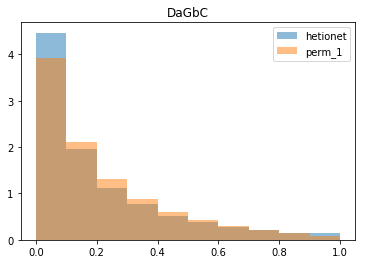

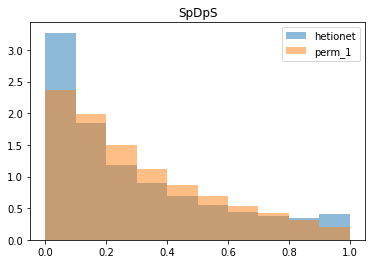

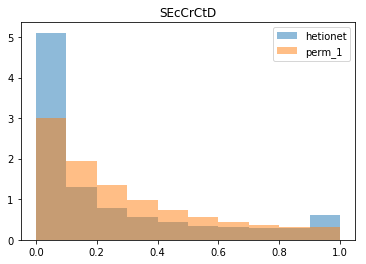

In [9]:
for metapath in metapaths:
    plt.figure()
    plt.title(metapath)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                     'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    plt.hist(df['p_value'], label='hetionet', alpha=0.5, density=True)
    

    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    plt.hist(df['p_value'], label='perm_1', alpha=0.5, density=True)
    plt.legend();

### Permutation 150

In [10]:
perms = hetmat.permutations.copy()
permat_1 = perms.pop('150')

In [ ]:
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0, dense_threshold=0.7, dtype='uint64')
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(pc_matrix, path)
    del pc_matrix
    
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
mean_dwpcs = dict()
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')
    mean_dwpcs[(metapath, 'dwpc', 0.5)] = dwpc_matrix.mean()
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0.5, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(dwpc_matrix, path)
    del dwpc_matrix

In [ ]:
for name, permat in tqdm.tqdm(perms.items()):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=16)
    for metapath in metapaths:
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=mean_dwpcs[(metapath, 'dwpc', 0.5)], damping=0.5)
        path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
        path.parent.mkdir(parents=True, exist_ok=True)
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.path_counts_cache = None

# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

In [ ]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(permat_1, metapath, damping=0.5, ignore_zeros=True, max_p_value=1.0)
    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    path.parent.mkdir(parents=True, exist_ok=True)
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')

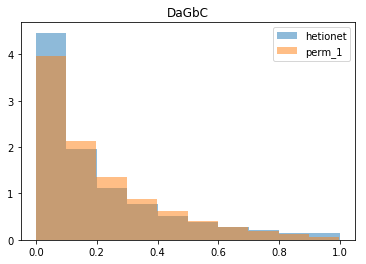

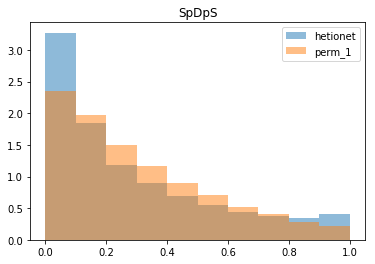

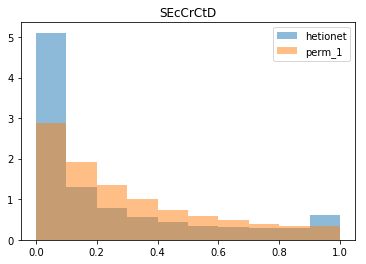

In [11]:
for metapath in metapaths:
    plt.figure()
    plt.title(metapath)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                     'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    plt.hist(df['p_value'], label='hetionet', alpha=0.5, density=True)
    

    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    plt.hist(df['p_value'], label='perm_1', alpha=0.5, density=True)
    plt.legend();